In [1]:
from importing import *
from TravelAndMutate.randominterface import NumpyRandomGenerator
from TravelAndMutate.system import System

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from time import time
from scipy.optimize import root_scalar

In [3]:
seed = np.prod([ord(c) for c in "TravelAndMutate"]).astype("uint32")
rng = NumpyRandomGenerator(seed)

In [4]:
def kernel(rng, tmax, params, commuting_mat):
    sys = System(rng.cpprng, 1, "mix", commuting_mat, params.to_records(index=False))
    sys.spreadForTime(tmax)
    return [pd.DataFrame.from_records(sys.getFullTrajectory(p), index="t") / params["N"][p] for p in range(params.shape[0])]

In [5]:
def Rinf_equation(Rinf, R0, s0):
    return 1 - Rinf - s0 * np.exp(-Rinf*R0)

,0,1,2,3,4
0,1.000,0.001,0.000,0.000,0.001
1,0.001,1.000,0.001,0.000,0.000
2,0.000,0.001,1.000,0.001,0.000
3,0.000,0.000,0.001,1.000,0.001
4,0.001,0.000,0.000,0.001,1.000


,N,beta,epsilon,mu,I0,R0
Patch,,,,,,
0,1000000,0.1,0.1,0.05,2,2.004
1,1000000,0.1,0.1,0.05,0,2.004
2,1000000,0.1,0.1,0.05,0,2.004
3,1000000,0.1,0.1,0.05,0,2.004
4,1000000,0.1,0.1,0.05,0,2.004


Duration per replica: 0.06 sec

Measured survived 0.76, expected 0.7490009999960161


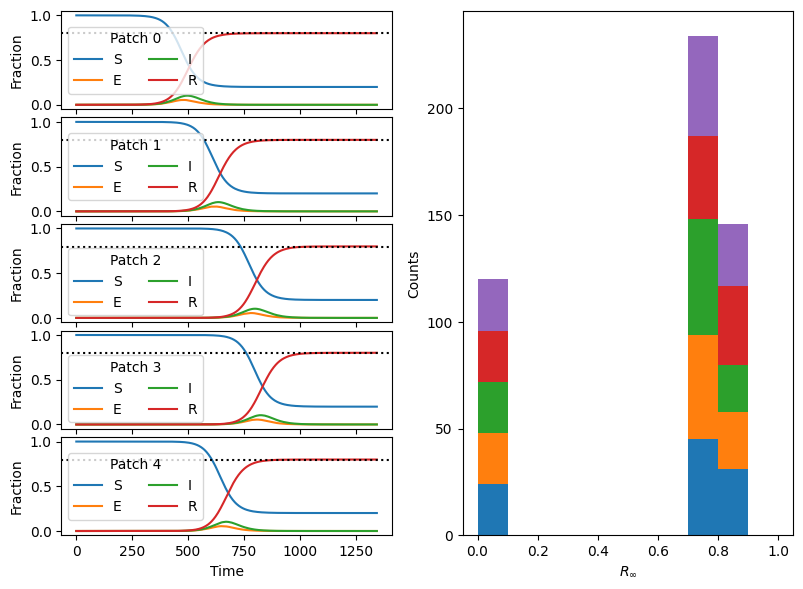

In [6]:
start = time()

Npatch = 5
c_ij = 1e-3

commuting = np.diag(np.full(Npatch, 1))
commuting = commuting + np.diag(np.full(Npatch-1, c_ij), -1)
commuting = commuting + np.diag(np.full(Npatch-1, c_ij), 1)
commuting[(Npatch-1,0),(0,Npatch-1)] = c_ij
display(pd.DataFrame(commuting))

tmax = 1500

params = pd.DataFrame()
params["N"] = np.full(Npatch, 1e6, dtype="u4")
params["beta"] = np.full(Npatch, 0.1)
params["epsilon"] = np.full(Npatch, 0.1)
params["mu"] = np.full(Npatch, 0.05)
params["I0"] = np.zeros(Npatch, dtype="u4")
params.loc[rng.rng.integers(Npatch), "I0"] = 2
params.index.name = "Patch"
display(params)

reps = 100
avgs = []
for i in range(reps):
	result = kernel(rng, tmax, params, commuting)
	avgs.append([r["R"].iloc[-1] for r in result])
avgs = np.array(avgs)

end = time()
print(f"Duration per replica: {np.round((end-start)/reps, 2)} sec")

params["R0"] = commuting @ (params["beta"] / params["mu"])

print()
print(f"Measured survived {np.sum(avgs > 0.2)/reps/Npatch}, expected {1-(1-1/params['R0'].mean())**params['I0'].sum()}")

fig = plt.figure(figsize=(8,6))
gs = plt.GridSpec(Npatch, 2)

axs = [fig.add_subplot(gs[0,0])]
axs = axs + [fig.add_subplot(gs[i,0], sharex=axs[0]) for i in range(1,Npatch)]
axs = axs + [fig.add_subplot(gs[:,1])]
for i in range(Npatch):
	result[i][["S","E","I","R"]].plot(ax=axs[i])
	axs[i].set_xlabel("Time")
	axs[i].set_ylabel("Fraction")
	Rinf = root_scalar(Rinf_equation, args=(params["R0"][i],1-params["I0"][i]/params["N"][i]), x0=params["R0"][i]).root
	axs[i].axhline(Rinf, color="k", linestyle=":")
	axs[i].set_ylim([-0.05,1.05])
	axs[i].legend(title=f"Patch {i}", ncol=2)

axs[-1].hist(avgs, bins=np.linspace(0,1,11), stacked=True)
axs[-1].set_ylabel("Counts")
axs[-1].set_xlabel(r"$R_\infty$")

fig.tight_layout(h_pad=0.1)
fig.savefig("../plots/chain-interacting_patches.png")